In [1]:
# P4
# https://www.bilibili.com/video/BV11yHXeuE9d?spm_id_from=333.788.videopod.episodes&vd_source=bc52a00e2c4b89fe3c07f7beea20e7ea&p=4

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])      #80%
Xdev, Ydev = build_dataset(words[n1:n2])  #10%
Xte, Yte = build_dataset(words[n2:])      #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [42]:
#MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [43]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))  # 随机32个输入作为一个批次训练
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb]  # emb
    embcat = emb.view(emb.shape[0],-1) # concatenate
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
     
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track
    if i %10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2958
  10000/ 200000: 2.0659
  20000/ 200000: 2.1454
  30000/ 200000: 2.3396
  40000/ 200000: 1.7961
  50000/ 200000: 2.2779
  60000/ 200000: 2.3716
  70000/ 200000: 2.2913
  80000/ 200000: 2.1287
  90000/ 200000: 2.1220
 100000/ 200000: 2.5308
 110000/ 200000: 2.0073
 120000/ 200000: 2.1328
 130000/ 200000: 1.9446
 140000/ 200000: 1.9434
 150000/ 200000: 2.0071
 160000/ 200000: 2.1007
 170000/ 200000: 1.9818
 180000/ 200000: 2.3530
 190000/ 200000: 1.9477


In [32]:
# 4 - dimensional example of issue
logits = torch.randn(4)*100 
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# 这里的理解，如果每个字母概率一样，损失函数是 3.2958
# 但是如果是随机值，第一批训练，模型的损失函数达到了 一二十
# 所以其实可以更好的初始化模型参数，让损失值刚开始就小
# 也就是说让 logits都相等即可
# 但因为初始化时，有整数和负数，接近 0 更好处理一些。
# 所以b2全部置为0
# 所以W2乘一个很小数的，为什么不直接置为 0 呢？

(tensor([149.8582, -13.7435, -90.0360, -48.8418]),
 tensor([1., 0., 0., 0.]),
 tensor(inf))

In [22]:
-torch.tensor(1/27).log()  #每个字母概率一样，损失函数是3.2958

tensor(3.2958)

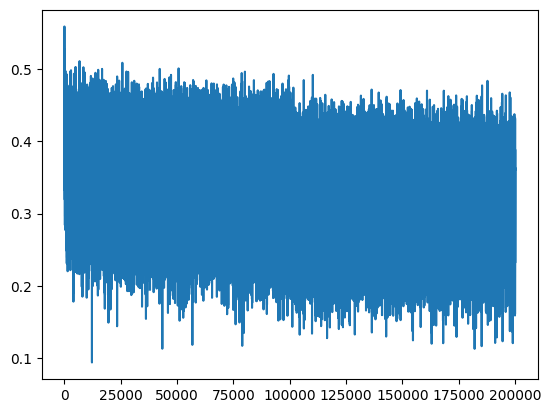

In [44]:
plt.plot(lossi)

In [45]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.072871208190918
val 2.1202549934387207


In [14]:
## sample采样
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        context = context[1:] + [ix]

        if ix == 0:
            break
    print(''.join(out))
        

emahor.
traslynne.
anger.
trysel.
gruv.
gyson.
meckontitar.
zovor.
talee.
igze.
nyah.
miab.
jayna.
vyrenkendayyah.
yohadinoria.
calliano.
dan.
jana.
jathgwytsa.
diman.


tensor([[ 2.1839, -0.5279, -0.4730, -0.1181,  1.0875, -0.1454, -0.0699,  1.9169,
         -0.4693, -0.1235,  2.1839, -0.5279, -0.4730, -0.1181,  1.0875, -0.1454,
         -0.0699,  1.9169, -0.4693, -0.1235,  2.1839, -0.5279, -0.4730, -0.1181,
          1.0875, -0.1454, -0.0699,  1.9169, -0.4693, -0.1235]],
       grad_fn=<ViewBackward0>)